In [1]:
# Import statements
import tensorflow as tf
import numpy as np
import scipy.io
import os
import matplotlib.pyplot as plt
import h5py
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
# Plot formatting defaults
plt.rc('ytick', direction='out')
plt.rc('grid', color='w', linestyle='solid')
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams.update({'font.size': 22})
plt.rc('xtick', direction='out')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

In [3]:
# Load in train and test data

mat = scipy.io.loadmat('W8_samples.mat')
W8_cell_data = mat['cell_data']

mat = scipy.io.loadmat('W9_samples.mat')
W9_cell_data = mat['cell_data']

del mat

# X_train, y_train = shuffle(W8_cell_data[:,1:], W8_cell_data[:,0])
X_train, X_valid, y_train, y_valid = train_test_split(W8_cell_data[:,1:], W8_cell_data[:,0], test_size=0.1, shuffle= True)

# X_train = W8_cell_data[:,1:]
# y_train = W8_cell_data[:,0]

# X_test, X_valid, y_test, y_valid = train_test_split(W9_cell_data[:,1:], W9_cell_data[:,0], test_size=0.1, shuffle= True)


X_test = W9_cell_data[:,1:]
y_test = W9_cell_data[:,0]

# Reshape for CNN: shape = (# samples, # timesteps, # features)
X_train = np.transpose(np.reshape(X_train, (X_train.shape[0], 2, int(X_train.shape[1]/2))), (0, 2, 1))
X_valid = np.transpose(np.reshape(X_valid, (X_valid.shape[0], 2, int(X_valid.shape[1]/2))), (0, 2, 1))
X_test = np.transpose(np.reshape(X_test, (X_test.shape[0], 2, int(X_test.shape[1]/2))), (0, 2, 1))

# Downsample test by 1/100 for testing
y_test = y_test[0::10]*100
X_test = X_test[0::10, :, :]
y_train = y_train*100
# X_train = X_train[0::50, :, :]
y_valid = y_valid*100
# X_valid = X_valid[0::50, :, :]

# Save dimensions for LSTM

n_samp, n_time, n_feat = X_train.shape

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(72811, 1200, 2)
(72811,)
(8091, 1200, 2)
(8091,)
(7109, 1200, 2)
(7109,)


(72811, 1200, 2)


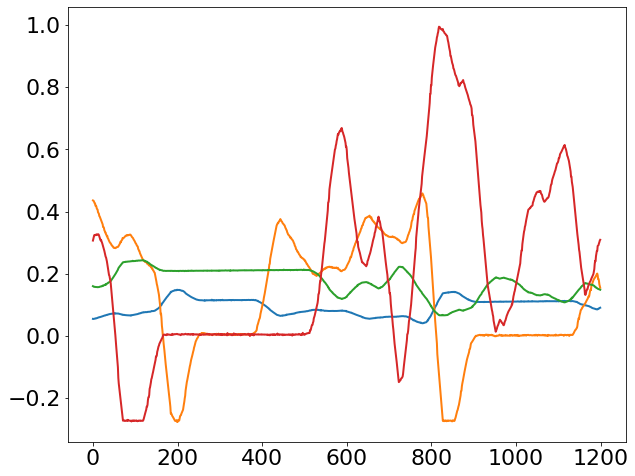

In [4]:
# Plot single training example
plt.plot(X_train[20,:,0])
plt.plot(X_train[20,:,1])
plt.plot(X_valid[20,:,0])
plt.plot(X_valid[20,:,1])
print(X_train.shape)
plt.show()

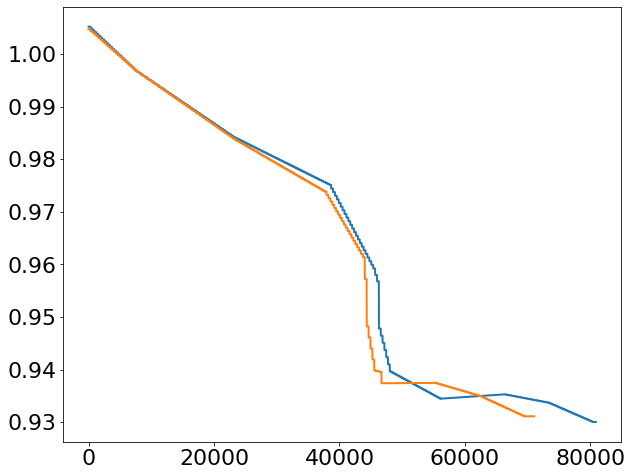

In [5]:
# Plot all output values
plt.plot(W8_cell_data[:,0])
plt.plot(W9_cell_data[:,0])
plt.show()

In [6]:
def build_cnn_model():
    model = keras.Sequential()
    model.add(layers.SeparableConv1D(100, 10, data_format='channels_last', padding='same'))
    model.add(layers.MaxPool1D(pool_size=(2)))
    model.add(layers.Conv1D(20, 5, padding='same'))
    model.add(layers.MaxPool1D(pool_size=(2)))
    # model.add(layers.Conv1D(10, 3, padding='same'))
    # model.add(layers.MaxPool1D(pool_size=(2)))
    # model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(200, activation="relu"))
    model.add(layers.Dense(20, activation="relu"))
    model.add(layers.Dense(1, activation="linear"))
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="mean_absolute_error",
        metrics=["mean_squared_error"],
    )
    return model

In [7]:
cnn_model = build_cnn_model()
# Check shape of model (need to instantiate input shape)
# cnn_model.build(input_shape=(500,1200,2))
# cnn_model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-24 22:18:23.004241: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-24 22:18:23.004461: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
history = cnn_model.fit(X_train,y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=1000,
                    verbose=2,
                    batch_size=480)

# history = cnn_model.fit(X_train,
#                     y_train,
#                     epochs=200,
#                     verbose=2,
#                     batch_size=480,
#                     validation_split=0.2)

# history = cnn_model.fit(X_train,
#                     y_train,
#                     epochs=100,
#                     verbose=2,
#                     batch_size=500,
#                     validation_split=0.2)
# 
# cnn_model.save("cnnmodel_w8_100_MSE_norm")

Epoch 1/1000


2022-05-24 22:18:32.761161: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-24 22:18:33.196793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-24 22:18:53.192869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


152/152 - 21s - loss: 12.7324 - mean_squared_error: 702.9404 - val_loss: 2.3980 - val_mean_squared_error: 6.8143 - 21s/epoch - 140ms/step
Epoch 2/1000
152/152 - 20s - loss: 2.5831 - mean_squared_error: 9.0130 - val_loss: 2.3796 - val_mean_squared_error: 7.1724 - 20s/epoch - 133ms/step
Epoch 3/1000
152/152 - 20s - loss: 2.6131 - mean_squared_error: 9.3777 - val_loss: 2.4326 - val_mean_squared_error: 6.8160 - 20s/epoch - 133ms/step
Epoch 4/1000
152/152 - 20s - loss: 2.4852 - mean_squared_error: 8.1084 - val_loss: 2.3886 - val_mean_squared_error: 6.9379 - 20s/epoch - 132ms/step
Epoch 5/1000
152/152 - 20s - loss: 2.4538 - mean_squared_error: 7.7093 - val_loss: 2.4076 - val_mean_squared_error: 6.7604 - 20s/epoch - 134ms/step
Epoch 6/1000
152/152 - 20s - loss: 2.7281 - mean_squared_error: 10.5131 - val_loss: 2.3883 - val_mean_squared_error: 6.8899 - 20s/epoch - 133ms/step
Epoch 7/1000
152/152 - 20s - loss: 2.4419 - mean_squared_error: 7.6202 - val_loss: 2.5036 - val_mean_squared_error: 7.238

  9/223 [>.............................] - ETA: 1s 

2022-05-25 09:24:58.989049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


223/223 [==============================] - 1s 6ms/step


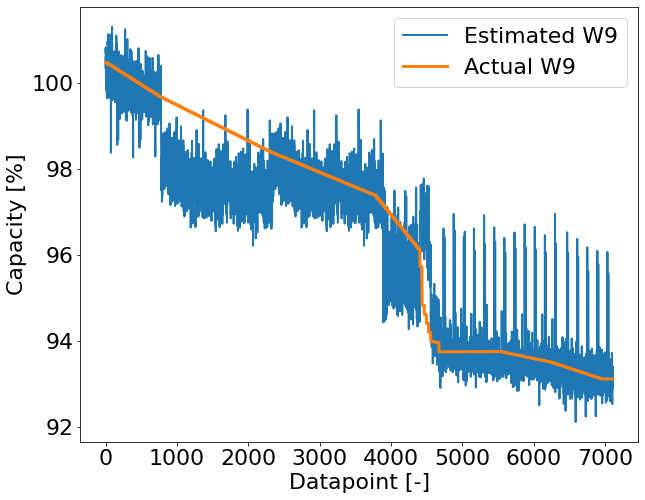

223/223 - 1s - loss: 0.6611 - mean_squared_error: 0.8445 - 1s/epoch - 6ms/step


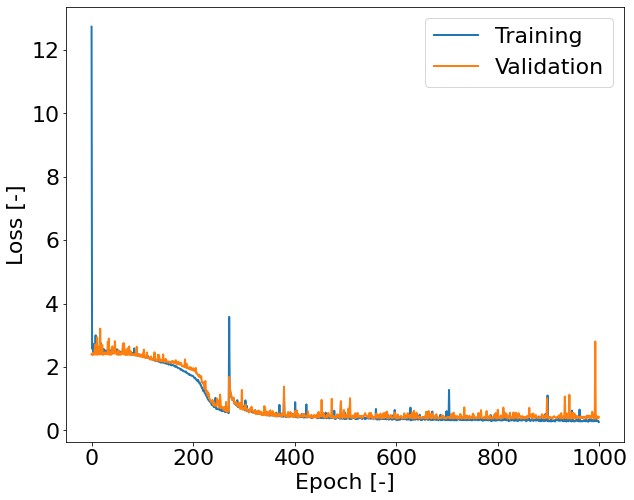

In [10]:
y_hat = cnn_model.predict(X_test)
y_hat_plot = np.ravel(y_hat)
plt.plot(y_hat_plot)
plt.plot(y_test, linewidth=3)
plt.legend(['Estimated W9', 'Actual W9'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()
cnn_model.evaluate(X_test, y_test, verbose=2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.xlabel("Epoch [-]")
plt.ylabel("Loss [-]")
plt.show()

In [9]:
cnn_model.save("cnnmodel_w8_1000_MAE")

INFO:tensorflow:Assets written to: cnnmodel_w8_1000_MAE/assets


INFO:tensorflow:Assets written to: cnnmodel_w8_1000_MAE/assets


231/231 [==============================] - 1s 6ms/step


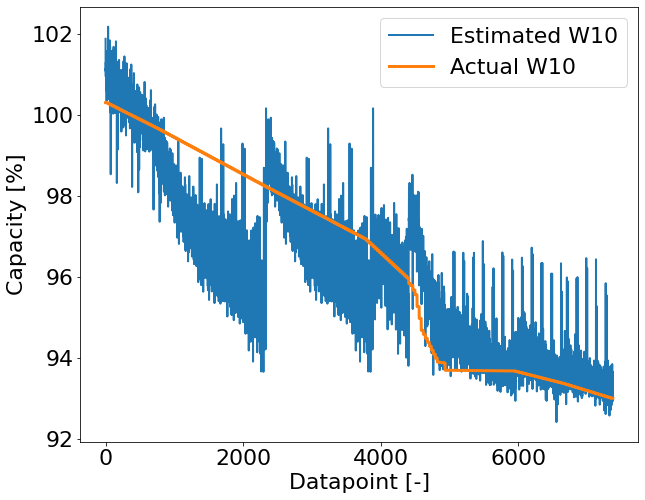

231/231 - 2s - loss: 0.9890 - mean_squared_error: 1.7936 - 2s/epoch - 7ms/step


[0.9889780879020691, 1.7935795783996582]

In [11]:
# Validate on W10 cell

mat = scipy.io.loadmat('W10_samples.mat')
W10_cell_data = mat['cell_data']

del mat

X_test_W10 = W10_cell_data[:,1:]
y_test_W10 = W10_cell_data[:,0]*100

# Reshape for CNN: shape = (# samples, # timesteps, # features)
X_test_W10 = np.transpose(np.reshape(X_test_W10, (X_test_W10.shape[0], 2, int(X_test_W10.shape[1]/2))), (0, 2, 1))

# Downsample test by 1/10th
y_test_W10 = y_test_W10[0::10]
X_test_W10 = X_test_W10[0::10, :, :]

y_hat_W10 = cnn_model.predict(X_test_W10)
y_hat_plot_W10 = np.ravel(y_hat_W10)
plt.plot(y_hat_plot_W10)
plt.plot(y_test_W10, linewidth=3)
plt.legend(['Estimated W10', 'Actual W10'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()
cnn_model.evaluate(X_test_W10, y_test_W10, verbose=2)


Validate on W5 cell

268/268 [==============================] - 2s 6ms/step


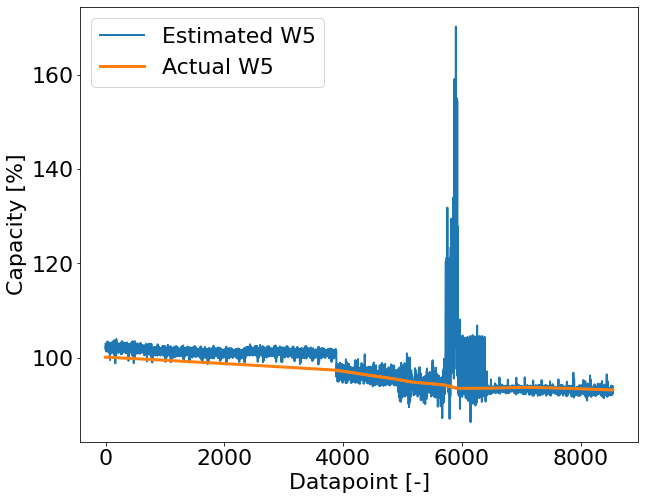

268/268 - 2s - loss: 2.1358 - mean_squared_error: 18.9871 - 2s/epoch - 6ms/step


[2.135807514190674, 18.987119674682617]

In [12]:
# Validate on W5 cell

mat = scipy.io.loadmat('W5_samples.mat')
W5_cell_data = mat['cell_data']

del mat

X_test_W5 = W5_cell_data[:,1:]
y_test_W5 = W5_cell_data[:,0]*100

# Reshape for CNN: shape = (# samples, # timesteps, # features)
X_test_W5 = np.transpose(np.reshape(X_test_W5, (X_test_W5.shape[0], 2, int(X_test_W5.shape[1]/2))), (0, 2, 1))

# Downsample test by 1/10th
y_test_W5 = y_test_W5[0::10]
X_test_W5 = X_test_W5[0::10, :, :]

y_hat_W5 = cnn_model.predict(X_test_W5)

y_hat_plot_W5 = np.ravel(y_hat_W5)
plt.plot(y_hat_plot_W5)
plt.plot(y_test_W5, linewidth=3)
plt.legend(['Estimated W5', 'Actual W5'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()
cnn_model.evaluate(X_test_W5, y_test_W5, verbose=2)

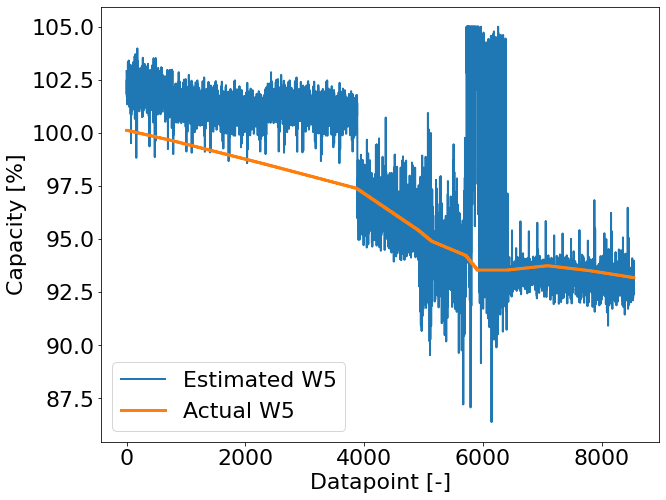

In [13]:
y_hat_plot_W5 = np.ravel(y_hat_W5)
y_hat_plot_w5_test = y_hat_plot_W5.copy()
y_hat_plot_w5_test[y_hat_plot_w5_test>105] = 105
plt.plot(y_hat_plot_w5_test)
plt.plot(y_test_W5, linewidth=3)
plt.legend(['Estimated W5', 'Actual W5'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()